In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [5]:
DATA_DIR = r"C:\Users\somes\OneDrive\Desktop\BrainTumorDataset\image"  

CATEGORIES = ["0","1","2","3"]
IMG_SIZE = 128


In [7]:
X = []
y = []

for label, category in enumerate(CATEGORIES):
    path = os.path.join(DATA_DIR, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(label)

X = np.array(X) / 255.0
X = np.expand_dims(X, axis=-1)
y = np.array(y)

print("Total images:", len(X))


Total images: 6380


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 150
BATCH = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical",   
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical",   
    subset="validation",
    shuffle=False               
)

num_classes = len(train_data.class_indices)
print("CLASSES:", train_data.class_indices)


Found 5104 images belonging to 4 classes.
Found 1276 images belonging to 4 classes.
CLASSES: {'0': 0, '1': 1, '2': 2, '3': 3}


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')   
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",           
    metrics=["accuracy"]
)

model.summary()




C:\Users\somes\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,484 (36.49 MB)

 Trainable params: 9,564,484 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Ensure 'model' is defined (run cell 6 first)
try:
    model
except NameError:
    raise RuntimeError("Please run the cell where 'model' is defined before running this cell.")

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # use categorical_crossentropy for multiclass
              metrics=['accuracy'])

EPOCHS = 10  # Set the number of epochs as desired

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)




Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - accuracy: 0.7273 - loss: 0.6412 - val_accuracy: 0.7508 - val_loss: 0.9013
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 304ms/step - accuracy: 0.8591 - loss: 0.3539 - val_accuracy: 0.7735 - val_loss: 0.6900
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - accuracy: 0.9042 - loss: 0.2452 - val_accuracy: 0.8205 - val_loss: 0.6927
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 307ms/step - accuracy: 0.9371 - loss: 0.1683 - val_accuracy: 0.8260 - val_loss: 0.7427
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 304ms/step - accuracy: 0.9624 - loss: 0.1003 - val_accuracy: 0.8519 - val_loss: 0.7931
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 50s 310ms/step - accuracy: 0.9741 - loss: 0.0769 - val_accuracy: 0.8354 - val_loss: 0.8409
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 51s 317ms/step - accuracy: 0.9841 - loss: 0.0478 - val_accuracy: 0.8370 - val_loss: 0.8241
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.9886 - loss: 0

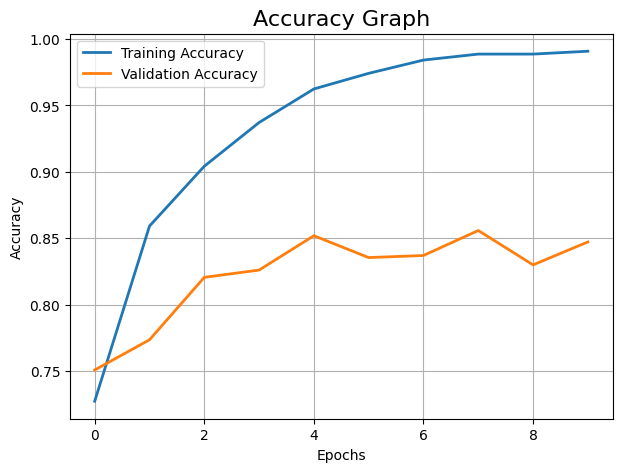

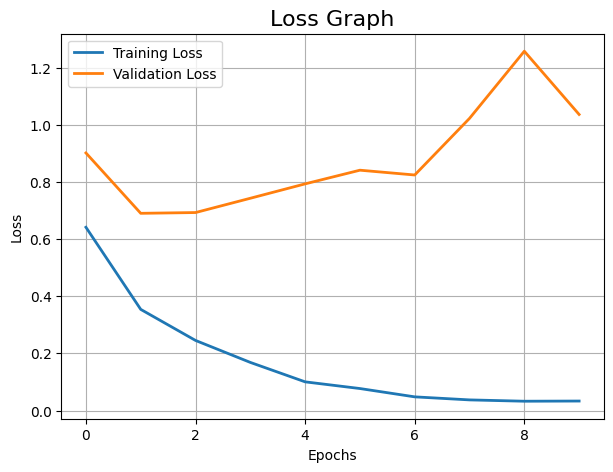

In [13]:

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Accuracy Graph", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Loss Graph", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


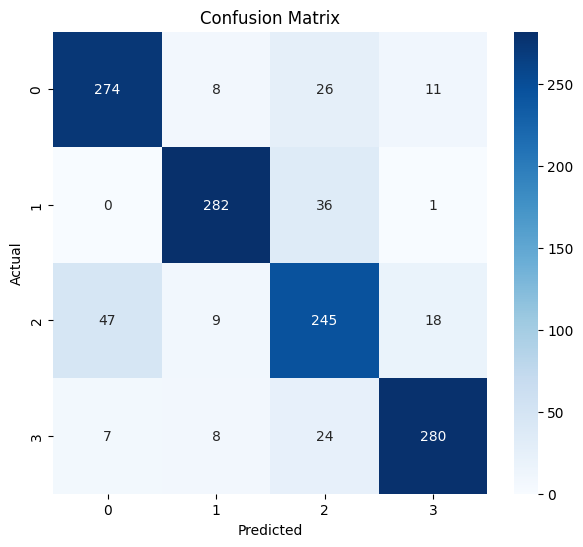

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       319
           1       0.92      0.88      0.90       319
           2       0.74      0.77      0.75       319
           3       0.90      0.88      0.89       319

    accuracy                           0.85      1276
   macro avg       0.85      0.85      0.85      1276
weighted avg       0.85      0.85      0.85      1276



In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_prob = model.predict(val_data)
y_pred = np.argmax(y_prob, axis=1)


y_true = val_data.classes


labels = list(val_data.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_true, y_pred, target_names=labels))


In [15]:
def predict_external_image(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=-1)
    img_resized = np.expand_dims(img_resized, axis=0)

    prediction = model.predict(img_resized)[0][0]

    if prediction > 0.5:
        result = "TUMOR"
    else:
        result = "NO TUMOR"

    print("Prediction:", result)

    plt.imshow(img, cmap='gray')
    plt.title(result)
    plt.axis('off')
    plt.show()


In [16]:
def predict_image_simple(path, model, class_names=['No_Tumor','Tumor'], img_size=(224,224), show=True):
    
    if not os.path.exists(path):
        return {"error": f"Image not found: {path}"}

    img = load_img(path, target_size=img_size)        
    x = img_to_array(img) / 255.0                     

    inp_shape = model.input_shape  
    if len(inp_shape) == 4:
        expected_ch = inp_shape[-1]
        if expected_ch == 1 and x.shape[-1] == 3:
            x = np.mean(x, axis=2, keepdims=True)   
        elif expected_ch == 3 and x.shape[-1] == 1:
            x = np.repeat(x, 3, axis=2)
    X = np.expand_dims(x, axis=0)
    preds = model.predict(X)
    
    if preds.shape[-1] == 1:
        p = float(preds[0][0])
        if p >= 0.5:
            label = class_names[1] if len(class_names)>1 else "Positive"
            conf = p
        else:
            label = class_names[0]
            conf = 1 - p
    else:
        idx = int(np.argmax(preds[0]))
        label = class_names[idx] if idx < len(class_names) else f"Class_{idx}"
        conf = float(preds[0][idx])
    if show:
        plt.imshow(plt.imread(path))
        plt.axis('off')
        plt.title(f"{label} ({conf*100:.2f}%)")
        plt.show()
    return {"label": label, "confidence": conf, "raw_pred": preds[0]}


In [18]:


def get_medical_advice_for_prediction(label):
    disclaimer = ("Always consult a qualified doctor.")

    common = [
        disclaimer,
        "• Bring original scan images and symptom notes to doctor.",
        "• If symptoms are severe, request urgent neurologist/neurosurgeon check."
    ]

    if str(label).lower() == "tumor":
          advice = [
        "⚕️ PROFESSIONAL GUIDANCE (For Doctor Review Only)",
        "",
        "• An abnormality has been detected in the brain scan image.",
        "• This is NOT a medical diagnosis — further evaluation by a specialist is required.",
        "",
        "🔷 Recommended Specialists:",
        "  • Neurologist – for clinical neurological evaluation.",
        "  • Neurosurgeon – for structural assessment and surgical considerations.",
        "  • Neuro-Oncologist – for tumour-specific evaluation and treatment planning.",
        "",
        "🔷 Next Clinical Steps (Doctor May Advise):",
        "  • Detailed neurological examination.",
        "  • MRI Brain with Contrast for clearer imaging.",
        "  • Review by a radiologist for structured radiology report.",
        "  • Biopsy or tissue sampling (if imaging suggests tumour-like mass).",
        "",
        "🔷 Multidisciplinary Tumour Board Review:",
        "  • Neurosurgeon",
        "  • Radiologist",
        "  • Neuro-Oncologist",
        "  • Pathologist",
        "",
        "🔷 Possible Treatment Pathways (Doctor Decides):",
        "  • Surgical removal of tumour (if accessible and safe).",
        "  • Radiation therapy.",
        "  • Chemotherapy or targeted therapy.",
        "  • Regular MRI monitoring for slow-growing/benign lesions.",
        "",

    ]

    else:
        advice = common + [
        "⚕️ PROFESSIONAL GUIDANCE (For Doctor Review Only)",
        "",
        "• The scan does not show features consistent with a tumour.",
        "• This is NOT a medical diagnosis — a doctor must confirm.",
        "",
        "🔷 Recommended Specialist (If Symptoms Exist):",
        "  • Neurologist – to evaluate headaches, dizziness, weakness, or vision issues.",
        "",
        "🔷 Typical Next Steps (Doctor May Suggest):",
        "  • Correlation of the scan findings with clinical symptoms.",
        "  • Routine monitoring if symptoms are mild or stable.",
        "  • Follow-up MRI/CT if symptoms persist, worsen, or change.",
        "",
        "🔷 Possible Causes of Non-Tumor Findings (Doctor Will Assess):",
        "  • Normal anatomical variations.",
        "  • Mild inflammation or infection (if clinically suggested).",
        "  • Sinus-related issues or vascular changes unrelated to tumour.",
        "",
        "🔷 When to Seek Specialist Care:",
        "  • Persistent or worsening headaches.",
        "  • Unexplained weakness, numbness, balance issues.",
        "  • Recurrent vomiting or seizures.",
        "",
    ]

    return advice 


def show_image_with_advice(image_path, label, confidence):

    if not os.path.exists(image_path):
        print("Image not found:", image_path)
        return

    advice_lines = get_medical_advice_for_prediction(label)
    confidence_pct = round(confidence * 100, 2)

    plt.figure(figsize=(8, 10))

    # Image display
    img = plt.imread(image_path)
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence_pct}%)")

    # Advice text display
    plt.subplot(2, 1, 2)
    plt.axis("off")
    advice_text = "\n".join(advice_lines)
    plt.text(0, 1, advice_text, fontsize=10, va='top')

    plt.tight_layout()
    plt.show()


In [61]:
import tensorflow as tf, numpy as np, cv2
def make_gradcam(image_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), (image_array.shape[2], image_array.shape[1]))
    return heatmap
# overlay:
# img = original RGB uint8, heatmap = output above
# overlay = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# result = cv2.addWeighted(img, 0.6, overlay, 0.4, 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
No tumor detected. Showing Non-Tumor advice...
['Always consult a qualified doctor.', '• Bring original scan images and symptom notes to doctor.', '• If symptoms are severe, request urgent neurologist/neurosurgeon check.', '⚕️ PROFESSIONAL GUIDANCE (For Doctor Review Only)', '', '• The scan does not show features consistent with a tumour.', '• This is NOT a medical diagnosis — a doctor must confirm.', '', '🔷 Recommended Specialist (If Symptoms Exist):', '  • Neurologist – to evaluate headaches, dizziness, weakness, or vision issues.', '', '🔷 Typical Next Steps (Doctor May Suggest):', '  • Correlation of the scan findings with clinical symptoms.', '  • Routine monitoring if symptoms are mild or stable.', '  • Follow-up MRI/CT if symptoms persist, worsen, or change.', '', '🔷 Possible Causes of Non-Tumor Findings (Doctor Will Assess):', '  • Normal anatomical variations.', '  • Mild inflammation or infection (if clinically suggested).', '  • Sinus-rel

C:\Users\somes\AppData\Local\Temp\ipykernel_20560\3792143086.py:97: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


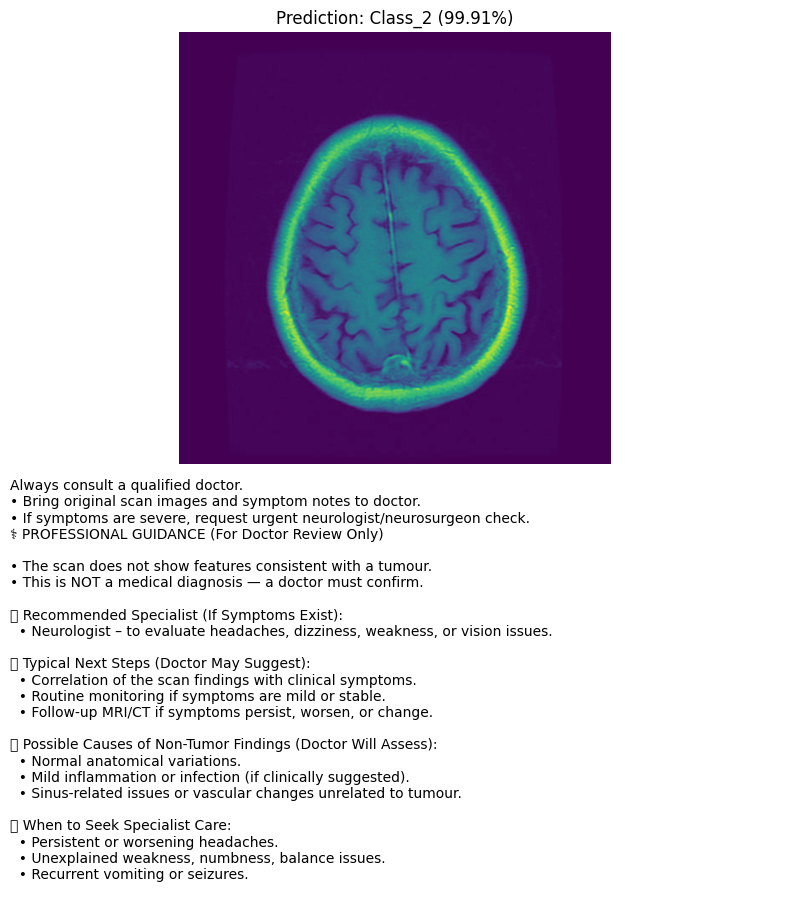

In [ ]:
# Predict label and confidence for the image
result = predict_image_simple(
    r"C:\Users\somes\Downloads\archive (4)\Testing\meningioma\Te-me_0290.jpg",
    model,
    class_names=['No_Tumor', 'Tumor'],
    img_size=(IMG_SIZE, IMG_SIZE),
    show=False
)
label = result["label"]
confidence = result["confidence"]

if label == "Tumor":
    advice_text = get_medical_advice_for_prediction(label)
    print(advice_text)

    # Show image + advice
    show_image_with_advice(
        r"C:\Users\somes\Downloads\archive (4)\Testing\meningioma\Te-me_0290.jpg",
        label,
        confidence
    )

else:
    print("No tumor detected. Showing Non-Tumor advice...")
    
    advice_text = get_medical_advice_for_prediction(label)
    print(advice_text)

    # Show image + advice
    show_image_with_advice(
        r"C:\Users\somes\Downloads\archive (4)\Testing\meningioma\Te-me_0290.jpg",
        label,
        confidence
    )



